In [1]:
# Import necessary libraries
import scanpy as sc
import pandas as pd
import anndata as ad
import numpy as np
import os
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import fisher_exact, ranksums, spearmanr
from itertools import combinations
from statsmodels.stats.multitest import multipletests

from datetime import datetime

# Get current date formatted as yymmdd
formatted_date = datetime.now().strftime('%y%m%d')
clustering_resolution = 0.3

#os.chdir('/home/ak431480')

## Load data

In [2]:
adata = sc.read_h5ad('/scratch/svc_td_grpc/users/kiviaho/lyu_2024_scs/preprocessed_h5ad/annotated_adata_obj_147180_cells_250813.h5ad')
adata.obs['type'] = adata.obs['type'].cat.reorder_categories(['PC','HSPC','CRPC'])

# Drop CRPCs
adata = adata[~(adata.obs['type'] == 'CRPC')]

# Drop Cycling cells
adata = adata[~(adata.obs['cell_type'] == 'Cycling cell')]

In [ ]:
adata.obs_names_make_unique()

# Create an empty column to hold cluster assignments
adata.obs['celltype_leiden'] = None  

# Iterate over all cell types
for ctype in tqdm(adata.obs['cell_type'].unique()):
    print(f'Processing {ctype}...')
    adata_subset = adata[adata.obs['cell_type'] == ctype].copy()
    
    # Compute neighbors and Leiden within this subset
    sc.pp.neighbors(adata_subset, use_rep='X_pca_harmony',random_state=24664712)
    sc.tl.leiden(adata_subset, resolution=0.3, key_added='leiden_tmp')
    
    # Map results back into the main object
    adata.obs.loc[adata_subset.obs_names, 'celltype_leiden'] = (
        ctype + '_' + adata_subset.obs['leiden_tmp'].astype(str)
    )


In [ ]:
# Drop cellular subtypes present with < 50 genes
drop_cell_subtypes = adata.obs['celltype_leiden'].value_counts()[adata.obs['celltype_leiden'].value_counts() < 50].index.to_list()

adata = adata[~(adata.obs['celltype_leiden'].isin(drop_cell_subtypes))]
n_types = len(adata.obs['celltype_leiden'].value_counts())
# Summary
print(f'{n_types} unique categories:')
adata.obs['celltype_leiden'].value_counts()

In [ ]:
# Get the unnormalized counts as the x layer
adata.X = adata.raw.X.copy()

In [ ]:
adata.write('./scs_data_clustered_annotated_250611_cellular_subtypes_for_cell2location.h5ad')

In [ ]:
### Find clusters that are mostly from a single sample and most likely technological

obs_data = adata.obs.copy()

vcounts = obs_data['celltype_leiden'].value_counts()

results = []  # collect rows

for col in vcounts.index:
    samplecounts = (
        obs_data[obs_data['celltype_leiden'] == col]['sample']
        .value_counts(normalize=True)
    )
    top_pct = samplecounts.iloc[0]*100
    top_sample = samplecounts.index[0]
    results.append({
        'celltype_leiden': col,
        'top_sample': top_sample,
        'top_pct': top_pct,
        'n_unique_samples': len(samplecounts[samplecounts != 0])
    })

# Convert to DataFrame
summary_df = pd.DataFrame(results)
summary_df = summary_df.set_index('celltype_leiden')

# Sort by descending top_pct
summary_df = summary_df.sort_values(by='top_pct', ascending=False)

sns.set_theme(style='white',font_scale=0.6,rc={
    'xtick.bottom': True,
    'ytick.left': True})

fig,ax = plt.subplots(figsize=(4,3))
sns.histplot(summary_df['top_pct'],binwidth=10, kde=True, ax=ax)
ax.spines[['top','right']].set_visible(False)
ax.axvline(x=75,linestyle='--', color='firebrick')
plt.show()

clusters_to_drop = summary_df[summary_df['top_pct'] > 75].index.tolist()
summary_df.loc[clusters_to_drop]


In [ ]:
# Drop the clusters
adata = adata[~(adata.obs['celltype_leiden'].isin(clusters_to_drop))]

In [ ]:
adata.obs['celltype_leiden'].value_counts()

In [ ]:
# Get the unnormalized counts as the x layer
adata.X = adata.raw.X.copy()

In [ ]:
# Save the adata object
adata.write(f'/scratch/svc_td_compbio/users/kiviaho/preprocessed_h5ad/lyu_2024_cell_subtypes_for_cell2location_mapping_{formatted_date}.h5ad')

## Calculate differential expression

In [ ]:
scs_adata = sc.read_h5ad('/scratch/svc_td_compbio/users/kiviaho/preprocessed_h5ad/lyu_2024_cell_subtypes_for_cell2location_mapping_251014.h5ad')
celltypes = scs_adata.obs['celltype_leiden'].value_counts().index.tolist()

In [ ]:
# One cluster vs all rest

output_path = "/home/ak431480/shafi_explant_project/scs_cluster_markers_vs_baseline_of_all_other.xlsx"
writer = pd.ExcelWriter(output_path, engine='openpyxl')

marker_genes_dict = {}
category_results = []
# First round: global DEGs
sc.tl.rank_genes_groups(
    scs_adata,
    groupby='celltype_leiden',
    reference='rest',
    layer='log1p',
    use_raw=False
)

for g in celltypes:
    deg_results_df = sc.get.rank_genes_groups_df(scs_adata, group=g, log2fc_min=1, pval_cutoff=0.05)
    deg_results_df['annotation'] = g  # mark which group this came from
    category_results.append(deg_results_df)

combined_df = pd.concat(category_results, ignore_index=True)
combined_df.to_excel(writer, sheet_name='DEGs', index=False)  # Excel sheet names max 31 chars

# Save workbook
writer.close()

print(f"Saved differential expression results to: {output_path}")


In [ ]:
output_path = "/home/ak431480/shafi_explant_project/scs_cluster_markers.xlsx"
writer = pd.ExcelWriter(output_path, engine='openpyxl')

marker_genes_dict = {}

# First round: global DEGs
sc.tl.rank_genes_groups(
    scs_adata,
    groupby='celltype_leiden',
    reference='rest',
    layer='log1p',
    use_raw=False
)

for g in celltypes:
    deg_results_df = sc.get.rank_genes_groups_df(scs_adata, group=g, log2fc_min=1, pval_cutoff=0.05)
    top_genes_str = '(' + ', '.join(deg_results_df['names'].tolist()[:3]) + ',\n'
    marker_genes_dict[g] = top_genes_str

# Second pass: within-category DEGs
top_level_categories = scs_adata.obs['cell_type'].cat.categories.tolist()

for top_category in top_level_categories:
    celltype_groups = [c for c in celltypes if top_category in c]

    adata = scs_adata[scs_adata.obs['celltype_leiden'].isin(celltype_groups)]
    sc.tl.rank_genes_groups(
        adata,
        groupby='celltype_leiden',
        groups=celltype_groups,
        reference='rest',
        layer='log1p',
        use_raw=False
    )

    category_results = []

    for g in celltype_groups:
        deg_results_df = sc.get.rank_genes_groups_df(adata, group=g, log2fc_min=1, pval_cutoff=0.05)
        deg_results_df['annotation'] = g  # mark which group this came from
        category_results.append(deg_results_df)

        # Update marker gene string
        marker_genes_dict[g] = marker_genes_dict[g] + ', '.join(deg_results_df['names'].tolist()[:3]) + ')'

    # Concatenate and save to Excel tab for this top_category
    if category_results:
        combined_df = pd.concat(category_results, ignore_index=True)
        combined_df.to_excel(writer, sheet_name=top_category[:31], index=False)  # Excel sheet names max 31 chars

# Save workbook
writer.close()

print(f"Saved differential expression results to: {output_path}")


## Plot cluster markers on umap

In [ ]:
# Calculate the differentially expressed genes in each group, put them into a string
marker_genes_dict = {}

sc.tl.rank_genes_groups(scs_adata,
        groupby='celltype_leiden',
        reference='rest',
        layer='log1p',
        use_raw=False)

for g in celltypes:
        deg_results_df = sc.get.rank_genes_groups_df(scs_adata,group=g,log2fc_min=1,pval_cutoff=0.05)

        # Extract the genes with the top 3 highest scores
        top_genes_str = '(' + ', '.join(deg_results_df['names'].tolist()[:3]) + ',\n'

        marker_genes_dict[g] = top_genes_str

# Second pass, markers for within the celltype group
top_level_categories = scs_adata.obs['cell_type'].cat.categories.tolist()

for top_category in top_level_categories:

        celltype_groups = [c for c in celltypes if top_category in c]

        adata = scs_adata[scs_adata.obs['celltype_leiden'].isin(celltype_groups)]
        sc.tl.rank_genes_groups(adata,
                groupby='celltype_leiden',
                groups=celltype_groups,
                reference='rest',
                layer='log1p',
                use_raw=False)

        for g in celltype_groups:
                deg_results_df = sc.get.rank_genes_groups_df(adata,group=g,log2fc_min=1,pval_cutoff=0.05)

                # Extract the genes with the top 3 highest scores
                marker_genes_dict[g] = marker_genes_dict[g] + ', '.join(deg_results_df['names'].tolist()[:3]) + ')'


In [ ]:
import matplotlib.pyplot as plt
import scanpy as sc

# ensure UMAP is computed
if 'X_umap' not in scs_adata.obsm:
    sc.tl.umap(scs_adata)

# extract coordinates
umap = scs_adata.obsm['X_umap']
clusters = scs_adata.obs['celltype_leiden'].cat.categories

# set up grid
fig, axes = plt.subplots(9, 5, figsize=(12, 20))
axes = axes.flatten()

for i, cluster in enumerate(clusters):
    ax = axes[i]
    
    highlight = scs_adata.obs['celltype_leiden'] == cluster

    # plot all cells in lightgray
    ax.scatter(umap[:, 0], umap[:, 1], s=0.1, color='lightgray', alpha=0.5, rasterized=True)
    # plot highlighted cluster in firebrick
    ax.scatter(umap[highlight, 0], umap[highlight, 1], s=0.1, color='firebrick', rasterized=True)

    ax.set_title(str(cluster) + ' ' + marker_genes_dict[cluster], fontsize=6)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)

# turn off extra axes if < 21 clusters
for j in range(len(clusters), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.savefig('/home/ak431480/shafi_explant_project/plots/scs_celltype_leiden_separately_highted_on_umap.pdf')
plt.show()


## Plot celltype fractions by treatment

In [2]:
scs_adata = sc.read_h5ad('/scratch/svc_td_compbio/users/kiviaho/preprocessed_h5ad/lyu_2024_cell_subtypes_for_cell2location_mapping_251014.h5ad')
scs_adata.obs_names = scs_adata.obs['sample'].astype(str) + '_' + scs_adata.obs_names

adata = scs_adata[scs_adata.obs['cell_type'] == 'Epithelial cell']

celltypes = scs_adata.obs['celltype_leiden'].value_counts().index.tolist()



In [3]:
# 1% threshold
min_cells = len(adata) * 0.01

# celltype sizes
counts = adata.obs['celltype_leiden'].value_counts()

# categories to remove
to_remove = counts[counts < min_cells].index

# filter adata
adata = adata[~adata.obs['celltype_leiden'].isin(to_remove)].copy()


In [4]:
prostate_lineage_signatures_dict = {}
prostate_lineage_signatures = pd.read_excel('/home/ak431480/prostate_lineage_signatures.xlsx',skiprows=1)
for gset in tqdm(prostate_lineage_signatures.columns):
    if 'Lum–' in gset:
        sig = prostate_lineage_signatures['Luminal'].dropna().tolist() + prostate_lineage_signatures[gset].dropna().tolist()
    if 'dLum' in gset:
        sig = prostate_lineage_signatures['Duct luminal'].dropna().tolist() + prostate_lineage_signatures[gset].dropna().tolist()
    if '_Basal' in gset:
        sig = prostate_lineage_signatures['Basal'].dropna().tolist() + prostate_lineage_signatures[gset].dropna().tolist()
    else:
        sig = prostate_lineage_signatures[gset].dropna().tolist()
    sc.tl.score_genes(adata,sig,score_name=gset,use_raw=False,layer='log1p')
    prostate_lineage_signatures_dict[gset] = prostate_lineage_signatures[gset].dropna().tolist()

celltype_order = adata.obs[['celltype_leiden','HALLMARK_ANDROGEN_RESPONSE']].groupby('celltype_leiden').median().sort_values('HALLMARK_ANDROGEN_RESPONSE',ascending=False).index.tolist()

  2%|▏         | 1/46 [00:01<00:47,  1.05s/it]

 11%|█         | 5/46 [00:04<00:34,  1.18it/s]

 33%|███▎      | 15/46 [00:12<00:25,  1.24it/s]

 37%|███▋      | 17/46 [00:14<00:23,  1.24it/s]

 50%|█████     | 23/46 [00:18<00:18,  1.25it/s]

 54%|█████▍    | 25/46 [00:20<00:16,  1.24it/s]

 59%|█████▊    | 27/46 [00:22<00:15,  1.23it/s]

 61%|██████    | 28/46 [00:23<00:14,  1.22it/s]

 65%|██████▌   | 30/46 [00:24<00:13,  1.21it/s]

 67%|██████▋   | 31/46 [00:25<00:12,  1.20it/s]

 70%|██████▉   | 32/46 [00:26<00:11,  1.20it/s]

       'IFNA14', 'IFNA13', 'IFNA17', 'IFNA4', 'CCL3L3', 'IL9'],
      dtype='object')


 72%|███████▏  | 33/46 [00:27<00:10,  1.21it/s]

 74%|███████▍  | 34/46 [00:27<00:09,  1.22it/s]

 78%|███████▊  | 36/46 [00:29<00:08,  1.21it/s]

 80%|████████  | 37/46 [00:30<00:07,  1.20it/s]

 83%|████████▎ | 38/46 [00:31<00:06,  1.19it/s]

 85%|████████▍ | 39/46 [00:32<00:05,  1.19it/s]

 87%|████████▋ | 40/46 [00:33<00:05,  1.19it/s]

 91%|█████████▏| 42/46 [00:34<00:03,  1.17it/s]

 93%|█████████▎| 43/46 [00:35<00:02,  1.20it/s]

100%|██████████| 46/46 [00:37<00:00,  1.21it/s]
/tmp/ipykernel_14663/3143398565.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  celltype_order = adata.obs[['celltype_leiden','HALLMARK_ANDROGEN_RESPONSE']].groupby('celltype_leiden').median().sort_values('HALLMARK_ANDROGEN_RESPONSE',ascending=False).index.tolist()


In [5]:
# Only keep cells with a positive CNV status
concat_obs_data = pd.read_csv('/scratch/svc_td_grpc/users/kiviaho/lyu_2024_scs/preprocessed_h5ad/epithelial_cancer_cell_annotation_20250818.csv',index_col=0)
concat_obs_data.index =  concat_obs_data['sample'].astype(str) + '_' + concat_obs_data.index
cnv_adata = scs_adata[scs_adata.obs_names.isin(concat_obs_data[concat_obs_data['CNV_status'] == 'CNVpos cancer'].index.tolist())].copy()
adata.obs = pd.merge(adata.obs,concat_obs_data[['CNV_status']],left_index=True,right_index=True,how='left')
adata.obs['CNV_status'] = adata.obs['CNV_status'].fillna('Benign')

In [6]:
sc.pp.neighbors(adata,use_rep='X_pca_harmony',random_state=529657)
sc.tl.umap(adata)

In [7]:
sns.set_palette(None)

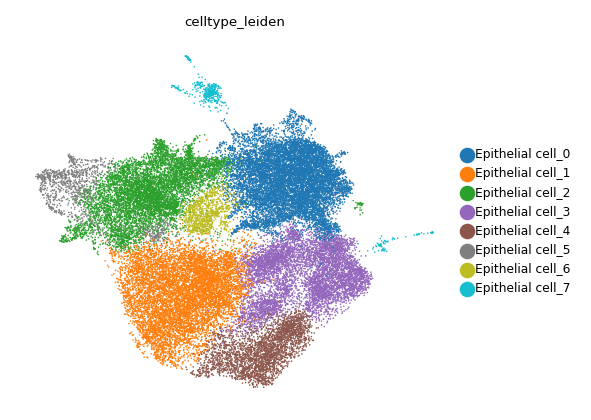

In [8]:
sc.set_figure_params(figsize=(3.5,3),fontsize=6,dpi_save=300)
sc.pl.umap(adata,color='celltype_leiden', size=2,frameon=False,palette='tab10',save='umap.pdf')

In [12]:
cluster_naming_dict = {
    'Epithelial cell_0':'AMACR+ cancer',
    'Epithelial cell_1':'PIGR+ progenitor-like',
    'Epithelial cell_2':'ARhigh mixed identity',
    'Epithelial cell_3':'ARlow mixed identity',
    'Epithelial cell_4':'KRT5+ basal',
    'Epithelial cell_5':'FOLH1+ cancer',
    'Epithelial cell_6':'NKX3-1+ cancer',
    'Epithelial cell_7':'CHGA+ neuroendocrine',

}

adata.obs['epithelial_celltype'] = adata.obs['celltype_leiden'].map(cluster_naming_dict)

/tmp/ipykernel_14663/2108314513.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=30)


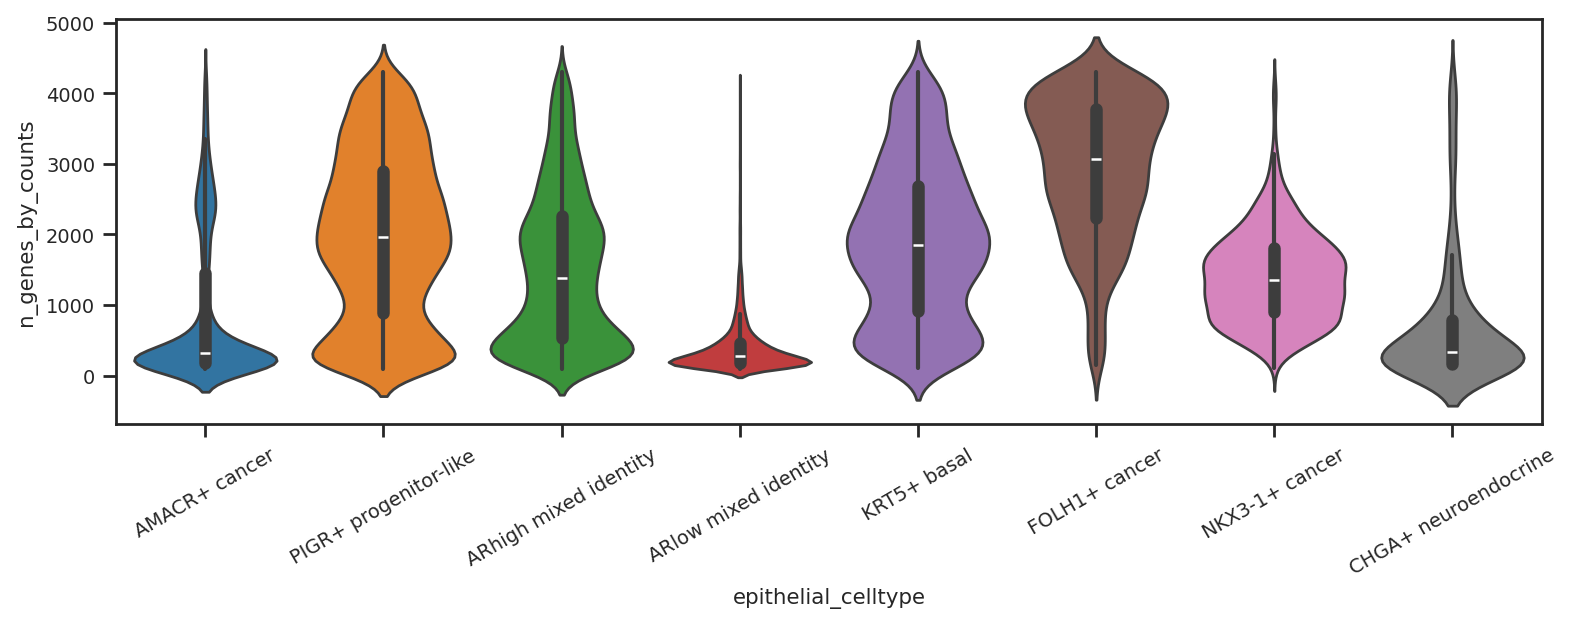

In [19]:
obs_data = adata.obs.copy()


sns.set_theme(style='white', font_scale=0.8, 
              palette='tab10',
              rc={'xtick.bottom': True, 'ytick.left': True})


fig, ax = plt.subplots(figsize=(10,4))
sns.violinplot(obs_data,
    x = 'epithelial_celltype',
    y = 'n_genes_by_counts',
    ax=ax,
    hue='epithelial_celltype'
    )
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.tight_layout()
plt.show()

/tmp/ipykernel_14663/3553400720.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=30)


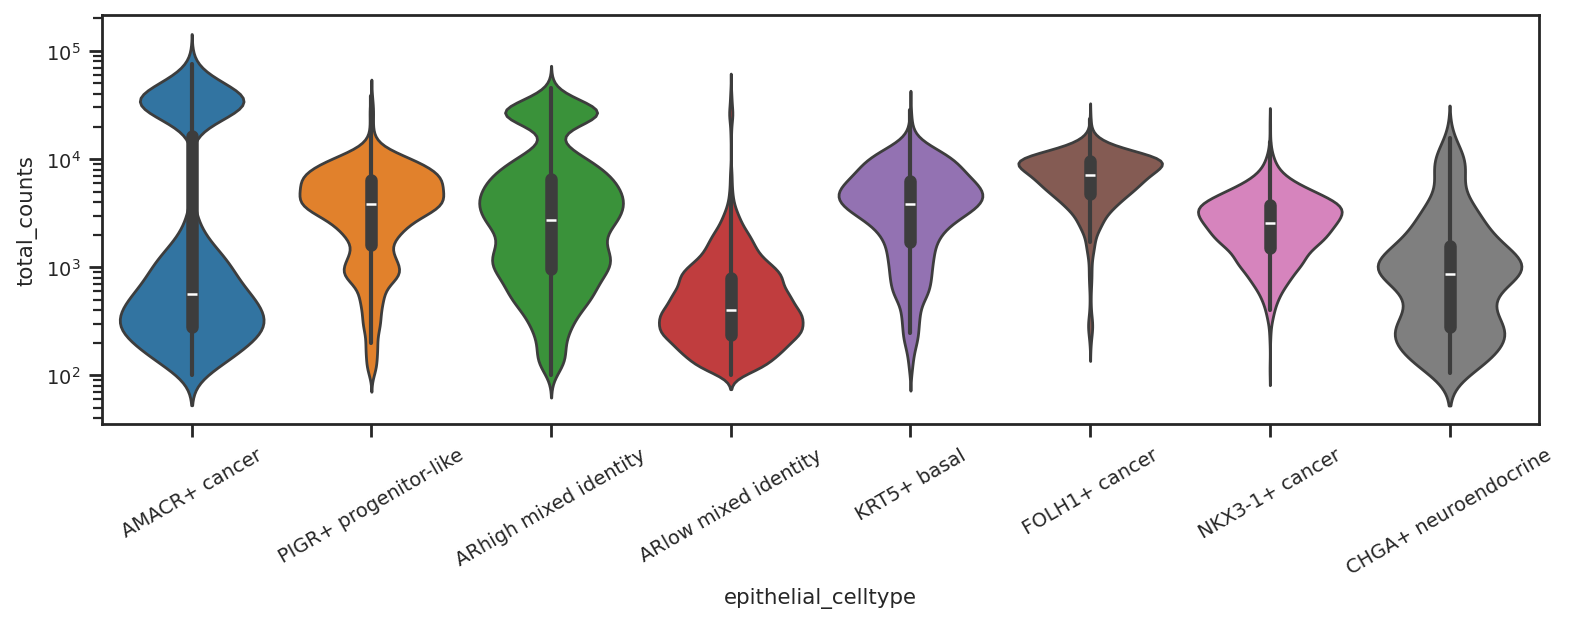

In [22]:
obs_data = adata.obs.copy()


sns.set_theme(style='white', font_scale=0.8, 
              palette='tab10',
              rc={'xtick.bottom': True, 'ytick.left': True})


fig, ax = plt.subplots(figsize=(10,4))
sns.violinplot(obs_data,
    x = 'epithelial_celltype',
    y = 'total_counts',
    ax=ax,
    hue='epithelial_celltype',
    log_scale=True
    )
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.tight_layout()
plt.show()

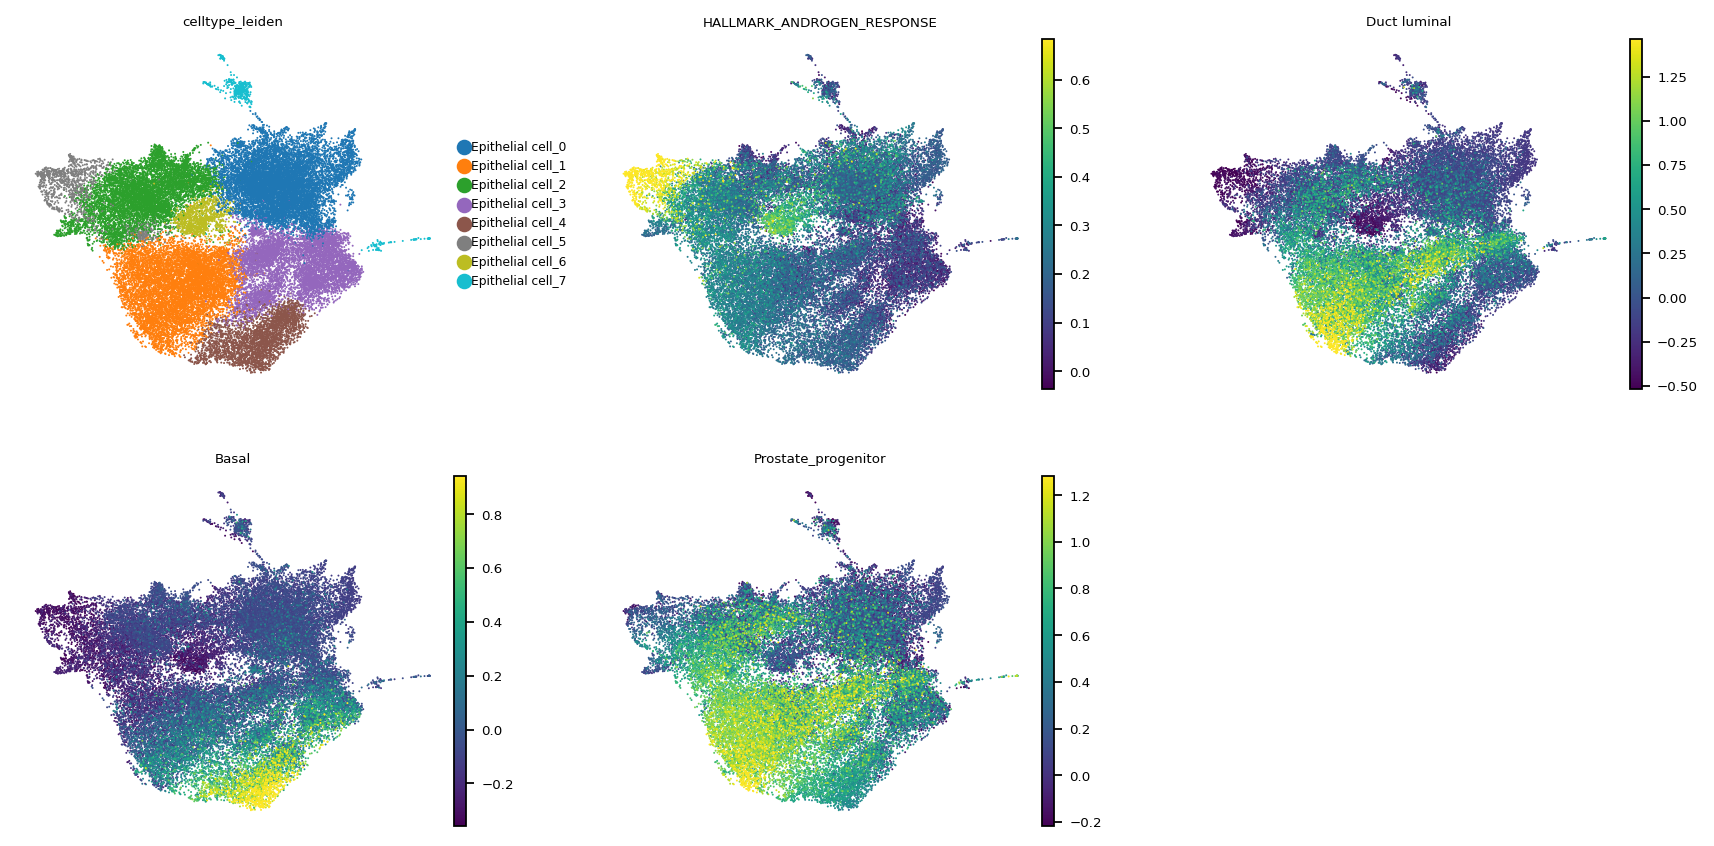

In [9]:
sc.set_figure_params(figsize=(3.5,3),fontsize=6)
sc.pl.umap(adata,color=['celltype_leiden','HALLMARK_ANDROGEN_RESPONSE','Duct luminal','Basal','Prostate_progenitor'],ncols=3,vmin='p1',vmax='p99',cmap='viridis',frameon=False)

/tmp/ipykernel_1357724/1299326464.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['celltype_leiden', group_col])
/tmp/ipykernel_1357724/1299326464.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  frac.groupby('celltype_leiden')['count'].transform('sum')


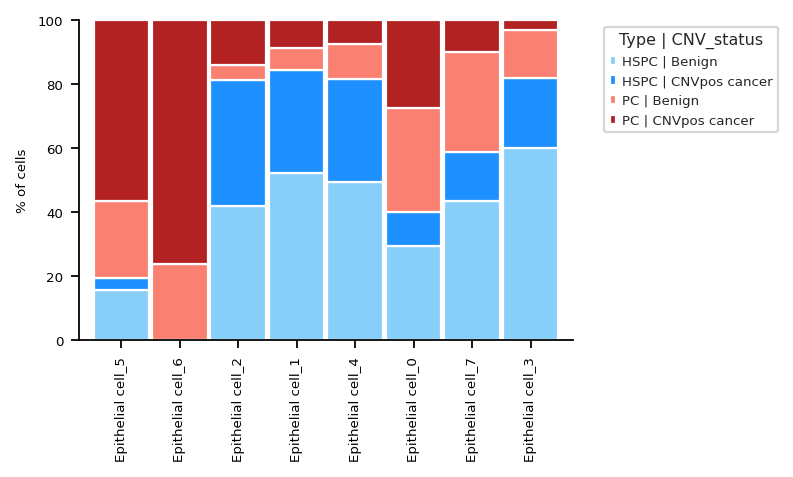

In [10]:
fig, ax = plt.subplots(figsize=(5, 3))

# --- Combine 'type' and 'CNV_status' into one column ---
adata.obs['type_CNV'] = (
    adata.obs['type'].astype(str)
    + ' | ' 
    + adata.obs['CNV_status'].astype(str)
)

# --- Compute fractions per celltype for the combined category ---
def compute_fractions(df, group_col):
    frac = (
        df.groupby(['celltype_leiden', group_col])
        .size()
        .reset_index(name='count')
    )
    frac['fraction'] = (
        frac['count'] /
        frac.groupby('celltype_leiden')['count'].transform('sum')
        * 100
    )
    frac_wide = (
        frac.pivot(index='celltype_leiden', columns=group_col, values='fraction')
        .fillna(0)
    )
    return frac_wide

combined_fraction = compute_fractions(adata.obs, 'type_CNV')

# --- Identify the column that represents cancer ---
# 👉 Replace this with the exact column name in your data
#cancer_col = [c for c in combined_fraction.columns if "PC" in c][0]
cancer_col = 'PC | CNVpos cancer'

# --- Sort using your external celltype_order list ---
combined_fraction = combined_fraction.reindex(celltype_order)

sns.set_theme(
    style='white',
    palette=sns.color_palette(['lightskyblue','dodgerblue','salmon','firebrick']),
    font_scale=0.6,
    rc={'xtick.bottom': True, 'ytick.left': True}
)

# --- Plot ---
combined_fraction.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    width=0.95
)

ax.set_ylabel('% of cells')
ax.set_xlabel('')
ax.set_ylim(0, 100)
ax.spines[['top', 'right']].set_visible(False)
ax.legend(
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    fontsize=6,
    title='Type | CNV_status'
)

plt.tight_layout()
plt.savefig('/home/ak431480/plots/CNA_barplot.pdf')
plt.show()


/tmp/ipykernel_1357724/318359709.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['sample', grpby, 'celltype_leiden'])
/tmp/ipykernel_1357724/318359709.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_counts['fraction'] = sample_counts['count'] / sample_counts.groupby('sample')['count'].transform('sum')
/tmp/ipykernel_1357724/318359709.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_c

     celltype_leiden      pval  pval_adj significance
0  Epithelial cell_0  0.000037  0.000299          ***
1  Epithelial cell_5  0.000184  0.000491          ***
2  Epithelial cell_6  0.000125  0.000491          ***
3  Epithelial cell_7  0.212543  0.212543             
4  Epithelial cell_4  0.014475  0.016542            *
5  Epithelial cell_3  0.005421  0.007228           **
6  Epithelial cell_1  0.001830  0.002928           **
7  Epithelial cell_2  0.000664  0.001327           **


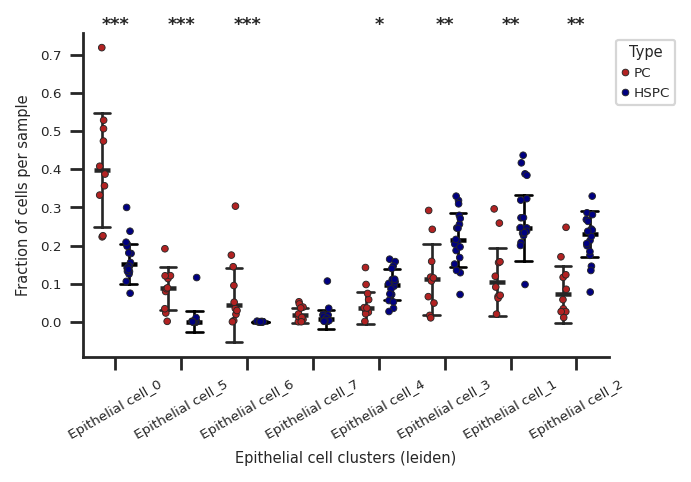

In [11]:
ctype = 'Epithelial cell'
grpby = 'type'

sns.set_theme(style='white', font_scale=0.55, 
              palette=sns.color_palette(['firebrick','navy']),
              rc={'xtick.bottom': True, 'ytick.left': True})

# --- Copy and filter data ---
obs_data = adata.obs.copy()
obs_data = obs_data[obs_data['cell_type'] == ctype].copy()
obs_data['celltype_leiden'] = obs_data['celltype_leiden'].cat.remove_unused_categories()

# Remove low-cell samples
vcounts = obs_data['sample'].value_counts()
obs_data = obs_data[obs_data['sample'].isin(vcounts[vcounts >=100].index)]
obs_data['sample'] = obs_data['sample'].cat.remove_unused_categories()

# --- Compute per-sample fractions ---
sample_counts = (
    obs_data
    .groupby(['sample', grpby, 'celltype_leiden'])
    .size()
    .reset_index(name='count')
)
sample_counts['fraction'] = sample_counts['count'] / sample_counts.groupby('sample')['count'].transform('sum')

# Remove mismatched sample/type combos
sample_counts = sample_counts[~((sample_counts['sample'].str.contains('^HSPC_')) & (sample_counts['type'] == 'PC'))]
sample_counts = sample_counts[~((sample_counts['sample'].str.contains('^PC_')) & (sample_counts['type'] == 'HSPC'))]

# --- Compute median difference PC - HSPC for each cluster ---
medians = (
    sample_counts.groupby(['celltype_leiden', grpby])['fraction']
    .median()
    .unstack()
)
medians['diff_PC_HSPC'] = medians['PC'] - medians['HSPC']

# --- Order clusters by difference (PC high → left, HSPC high → right) ---
celltype_order = medians.sort_values('diff_PC_HSPC', ascending=False).index.tolist()

# --- Statistical tests (MWU) ---
types = sample_counts[grpby].unique()
pvals = []
for celltype in celltype_order:
    data_sub = sample_counts[sample_counts['celltype_leiden'] == celltype]
    group1 = data_sub.loc[data_sub['type'] == 'PC', 'fraction']
    group2 = data_sub.loc[data_sub['type'] == 'HSPC', 'fraction']
    if len(group1) > 0 and len(group2) > 0:
        stat, p = ranksums(group1, group2, alternative='two-sided')
    else:
        p = np.nan
    pvals.append({'celltype_leiden': celltype, 'pval': p})

pval_df = pd.DataFrame(pvals)

# --- BH correction ---
pvals_clean = pval_df['pval'].dropna()
reject, pvals_corrected, _, _ = multipletests(pvals_clean, method='fdr_bh')
pval_df['pval_adj'] = np.nan
pval_df.loc[pvals_clean.index, 'pval_adj'] = pvals_corrected

# --- Convert adjusted p-values to significance stars ---
def p_to_star(p):
    if np.isnan(p):
        return ""
    elif p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return ""

pval_df['significance'] = pval_df['pval_adj'].apply(p_to_star)

# --- Plot ---
plt.figure(figsize=(4, 3))
sns.stripplot(
    data=sample_counts,
    x='celltype_leiden',
    y='fraction',
    hue=grpby,
    order=celltype_order,
    dodge=True,
    linewidth=0.4,
    size=3
)

sns.pointplot(
    data=sample_counts,
    x='celltype_leiden',
    y='fraction',
    hue=grpby,
    order=celltype_order,
    estimator='median',
    errorbar='sd',
    dodge=0.4,
    join=False,
    capsize=0.25,
    errwidth=1.2,
    markers='_',
    linestyles='',
    color='black',
    legend=False
)

# Annotate significance above boxes
y_max = sample_counts['fraction'].max()
for i, row in enumerate(pval_df.itertuples()):
    plt.text(i, y_max * 1.05, row.significance, ha='center', va='bottom', fontsize=8, fontweight='bold')

print(pval_df)
plt.xlabel('Epithelial cell clusters (leiden)')
plt.ylabel('Fraction of cells per sample')
plt.xticks(rotation=30)
sns.despine()
plt.tight_layout()
plt.legend(title='Type', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()



/tmp/ipykernel_211424/3208940664.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['sample', grpby, 'celltype_leiden'])
/tmp/ipykernel_211424/3208940664.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_counts['fraction'] = sample_counts['count'] / sample_counts.groupby('sample')['count'].transform('sum')
/tmp/ipykernel_211424/3208940664.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_c

     celltype_leiden      pval  pval_adj significance
0  Epithelial cell_0  0.000037  0.000299          ***
1  Epithelial cell_5  0.000184  0.000491          ***
2  Epithelial cell_6  0.000125  0.000491          ***
3  Epithelial cell_7  0.212543  0.212543             
4  Epithelial cell_4  0.014475  0.016542            *
5  Epithelial cell_3  0.005421  0.007228           **
6  Epithelial cell_1  0.001830  0.002928           **
7  Epithelial cell_2  0.000664  0.001327           **


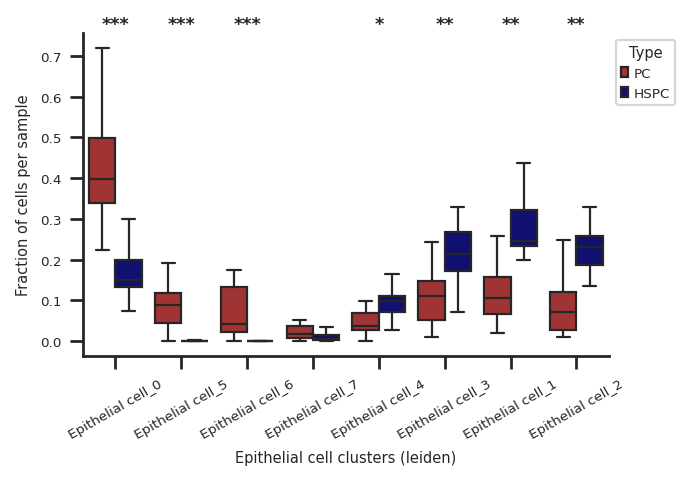

In [16]:
ctype = 'Epithelial cell'
grpby = 'type'

sns.set_theme(style='white', font_scale=0.55, 
              palette=sns.color_palette(['firebrick','navy']),
              rc={'xtick.bottom': True, 'ytick.left': True})

# --- Copy and filter data ---
obs_data = adata.obs.copy()
obs_data = obs_data[obs_data['cell_type'] == ctype].copy()
obs_data['celltype_leiden'] = obs_data['celltype_leiden'].cat.remove_unused_categories()

# Remove low-cell samples
vcounts = obs_data['sample'].value_counts()
obs_data = obs_data[obs_data['sample'].isin(vcounts[vcounts >=100].index)]
obs_data['sample'] = obs_data['sample'].cat.remove_unused_categories()

# --- Compute per-sample fractions ---
sample_counts = (
    obs_data
    .groupby(['sample', grpby, 'celltype_leiden'])
    .size()
    .reset_index(name='count')
)
sample_counts['fraction'] = sample_counts['count'] / sample_counts.groupby('sample')['count'].transform('sum')

# Remove mismatched sample/type combos
sample_counts = sample_counts[~((sample_counts['sample'].str.contains('^HSPC_')) & (sample_counts['type'] == 'PC'))]
sample_counts = sample_counts[~((sample_counts['sample'].str.contains('^PC_')) & (sample_counts['type'] == 'HSPC'))]

# --- Compute median difference PC - HSPC for each cluster ---
medians = (
    sample_counts.groupby(['celltype_leiden', grpby])['fraction']
    .median()
    .unstack()
)
medians['diff_PC_HSPC'] = medians['PC'] - medians['HSPC']

# --- Order clusters by difference (PC high → left, HSPC high → right) ---
celltype_order = medians.sort_values('diff_PC_HSPC', ascending=False).index.tolist()

# --- Statistical tests (MWU) ---
types = sample_counts[grpby].unique()
pvals = []
for celltype in celltype_order:
    data_sub = sample_counts[sample_counts['celltype_leiden'] == celltype]
    group1 = data_sub.loc[data_sub['type'] == 'PC', 'fraction']
    group2 = data_sub.loc[data_sub['type'] == 'HSPC', 'fraction']
    if len(group1) > 0 and len(group2) > 0:
        stat, p = ranksums(group1, group2, alternative='two-sided')
    else:
        p = np.nan
    pvals.append({'celltype_leiden': celltype, 'pval': p})

pval_df = pd.DataFrame(pvals)

# --- BH correction ---
pvals_clean = pval_df['pval'].dropna()
reject, pvals_corrected, _, _ = multipletests(pvals_clean, method='fdr_bh')
pval_df['pval_adj'] = np.nan
pval_df.loc[pvals_clean.index, 'pval_adj'] = pvals_corrected

# --- Convert adjusted p-values to significance stars ---
def p_to_star(p):
    if np.isnan(p):
        return ""
    elif p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return ""

pval_df['significance'] = pval_df['pval_adj'].apply(p_to_star)

# --- Plot ---
plt.figure(figsize=(4, 3))
sns.boxplot(
    data=sample_counts,
    x='celltype_leiden',
    y='fraction',
    hue=grpby,
    order=celltype_order,
    dodge=True,
    fliersize=0
    #linewidth=0.4,
    #size=3
)

# Annotate significance above boxes
y_max = sample_counts['fraction'].max()
for i, row in enumerate(pval_df.itertuples()):
    plt.text(i, 1.05*y_max, row.significance, ha='center', va='bottom', fontsize=8, fontweight='bold')
    #plt.text(i, sample_counts.loc[sample_counts['celltype_leiden'] == row[1],'fraction'].max(), row.significance, ha='center', va='bottom', fontsize=8, fontweight='bold')

print(pval_df)
plt.xlabel('Epithelial cell clusters (leiden)')
plt.ylabel('Fraction of cells per sample')
plt.xticks(rotation=30)
sns.despine()
plt.tight_layout()
plt.legend(title='Type', bbox_to_anchor=(1, 1), loc='upper left')
plt.savefig('/home/ak431480/plots/cluster_fraction_boxplot.pdf')
plt.show()



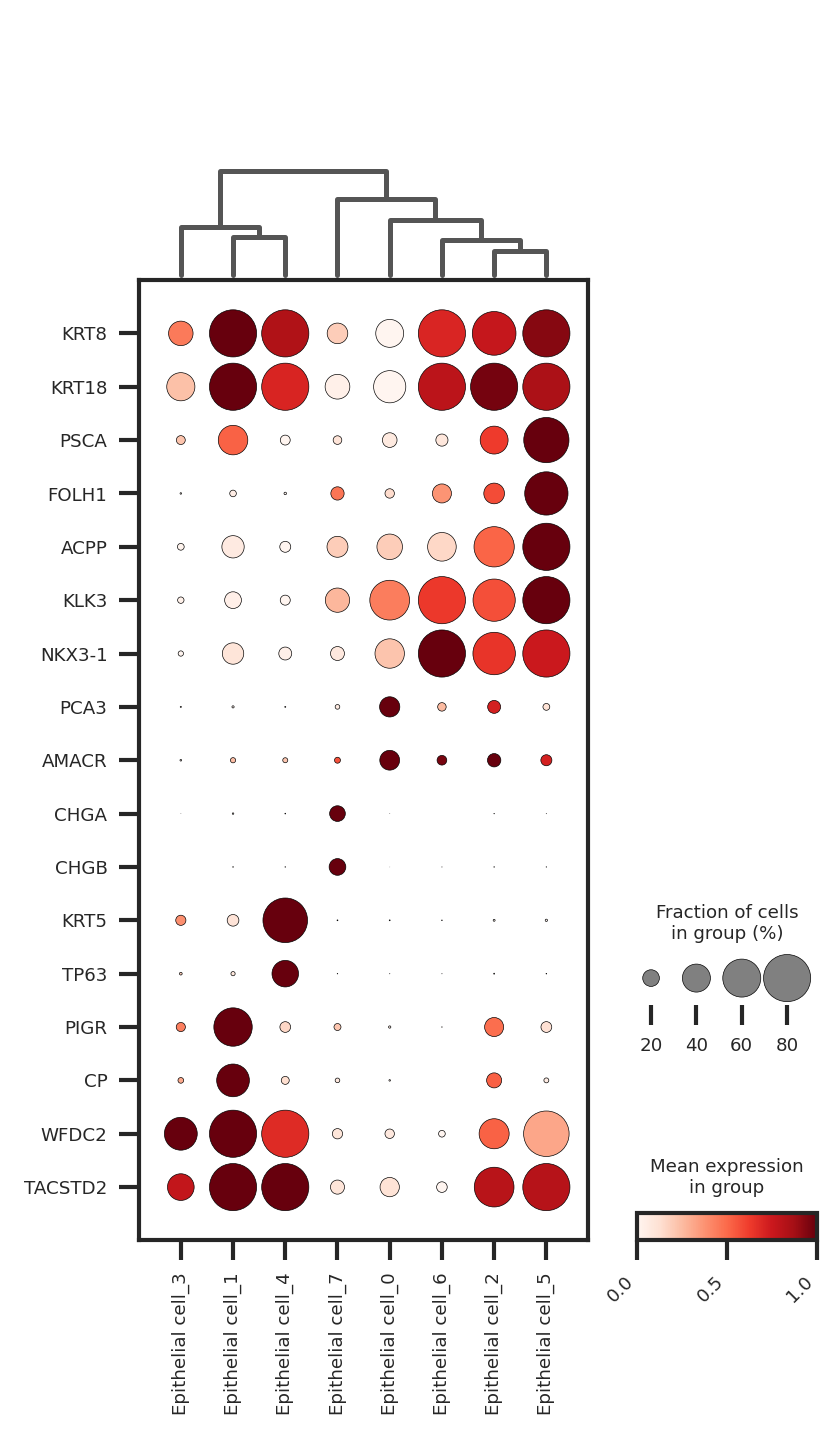

In [23]:
gene_markers = [
    'KRT8','KRT18','PSCA',
    'FOLH1','ACPP',
    'KLK3','NKX3-1',
    'PCA3','AMACR',
    'CHGA','CHGB', 
    'KRT5', 'TP63',
    #'KRT13','LY6D',
    'PIGR','CP',
    'WFDC2','TACSTD2',

]

# --- Plot ---
fig, ax = plt.subplots(figsize=(3.5, 6), dpi=120)
sc.pl.dotplot(
    adata,
    groupby='celltype_leiden',
    categories_order=celltype_order,
    var_names=gene_markers,
    standard_scale='var',
    dendrogram=True,
    cmap='Reds',
    use_raw=False,
    layer='log1p',
    swap_axes=True,
    dot_max=0.8,
    ax=ax,
    show=False
)
ax.invert_xaxis()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('/home/ak431480/plots/dotplot_sorted.pdf')
plt.show()

In [24]:
adata

AnnData object with n_obs × n_vars = 38217 × 26261
    obs: 'doublet', 'doublet_score', 'sample', 'type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cell_type', 'celltype_leiden', 'TISS', 'TISS long', 'Basal', 'Duct luminal', 'Luminal', 'B1_Basal-ESR1', 'B2_Basal', 'B3_Basal-GPRC5A', 'B4_Basal', 'B5_Basal-VCAN', 'B6_Basal-IC1', 'd1_dLum-Club', 'd2_dLum-KRT4', 'd3_dLum-LTF', 'd4_dLum-NKX3-1', 'd5_dLum', 'd6_dLum-CNMD', 'Lum−LTF', 'Lum−SFTPA2', 'Lum−TGM4', 'Lum−type1', 'Lum−type2', 'Prostate_progenitor', 'BPECT Luminal Identity', 'BPECT Basal Identity', 'BPECT Club Identity', 'BPECT Hillock Identity', 'CRPC-AR', 'CRPC-WNT', 'CRPC-NE', 'CRPC-SCL', 'JAK_STAT_FGFR', 'IL1B MDSCs', 'PMN-MDSCs', 'HALLMARK_ANDROGEN_RESPONSE', 'HALLMARK_IL6_JAK_STAT3_SIGNALING', 'HALLMARK_PI3K_AKT_MTOR_SIGNALING', 'HALLMARK_TNFA_SIGNALING_VIA_NFKB', 'HALLMARK_INTERFERON_ALPHA_RESPONSE', 'HALLMARK_INTERFERON_GAMMA_RESPONSE', 'Housekeeping', 'PTEN_LOSS_UP', 'PTEN_LOSS_DOWN'

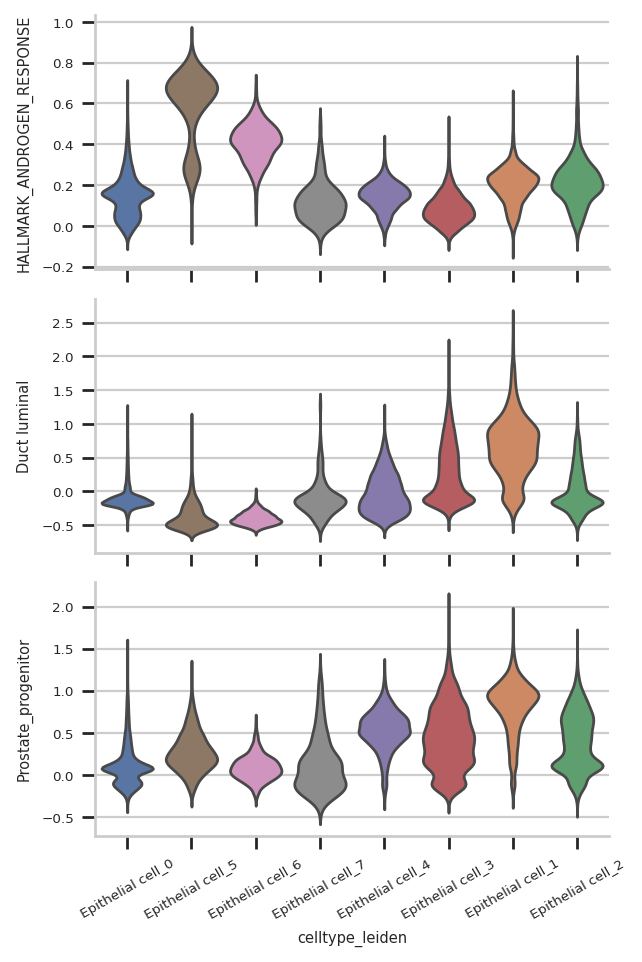

In [20]:
sns.set_theme(style='whitegrid', font_scale=0.55,
    rc={
    'xtick.bottom': True,
    'ytick.left': True
})


signatures = ['HALLMARK_ANDROGEN_RESPONSE','Duct luminal','Prostate_progenitor']

sig = 'HALLMARK_ANDROGEN_RESPONSE'
fig,axs = plt.subplots(3,1,figsize = (4,6),sharex=True)
for i,sig in enumerate(signatures):
    ax = axs[i]
    sns.violinplot(obs_data,
        x = 'celltype_leiden',
        y = sig,
        order = celltype_order,
        hue = 'celltype_leiden',
        inner=None,
        ax=ax
    )
    plt.xticks(rotation=30)
    ax.spines[['top','right']].set_visible(False)

plt.tight_layout()
plt.savefig('/home/ak431480/plots/violinplots.pdf')
plt.show()


### Dotplot for gene markers

/tmp/ipykernel_194265/1556887996.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby(['celltype_leiden', group_col]).size().reset_index(name='count')


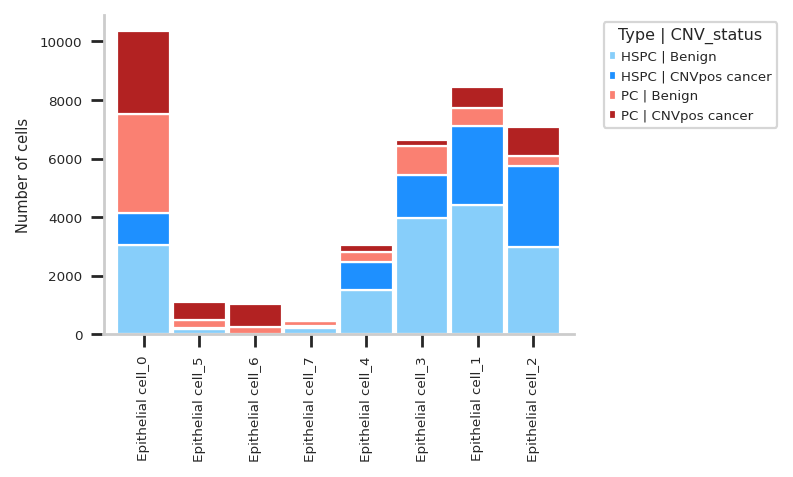

In [32]:
fig, ax = plt.subplots(figsize=(5, 3))

# --- Combine 'type' and 'CNV_status' into one column ---
adata.obs['type_CNV'] = adata.obs['type'].astype(str) + ' | ' + adata.obs['CNV_status'].astype(str)

# --- Compute raw counts per celltype for each type_CNV ---
def compute_counts(df, group_col):
    counts = df.groupby(['celltype_leiden', group_col]).size().reset_index(name='count')
    counts_wide = counts.pivot(index='celltype_leiden', columns=group_col, values='count').fillna(0)
    return counts_wide

combined_counts = compute_counts(adata.obs, 'type_CNV')

# --- Sort using your external celltype_order list ---
combined_counts = combined_counts.reindex(celltype_order)


sns.set_theme(
    style='white',
    palette=sns.color_palette(['lightskyblue','dodgerblue','salmon','firebrick']),
    font_scale=0.6,
    rc={'xtick.bottom': True, 'ytick.left': True}
)

combined_counts.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    width=0.95
)

ax.set_ylabel('Number of cells')
ax.set_xlabel('')
ax.spines[['top', 'right']].set_visible(False)
ax.legend(
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    fontsize=6,
    title='Type | CNV_status'
)

plt.tight_layout()

plt.show()


In [88]:
celltype_order = combined_fraction.index.tolist()

/tmp/ipykernel_813410/1784222211.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_expr = expr.groupby('decile_cat').mean()


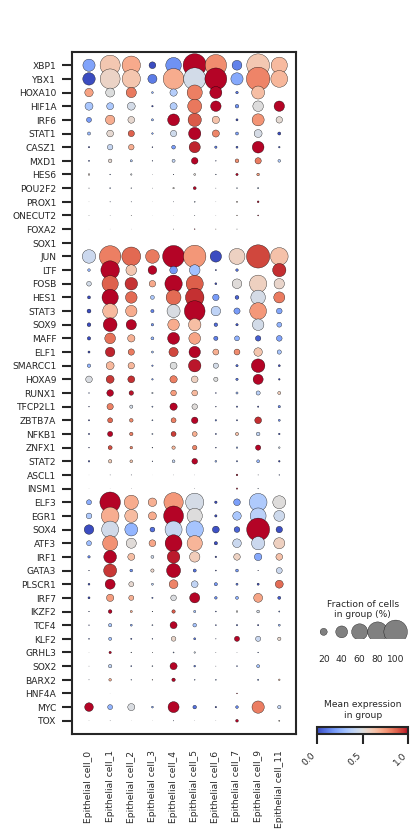

In [13]:
# Chan et al. Science 2022
gene_markers = [
    "HIF1A", "FOSB", "NFKB1", "IRF6", "HES1", "MAFF", "JUN", "RUNX1", "ATF3", # Transtition
    "ELF1", "MYC", "EGR1", "ZBTB7A", "SOX9", "IKZF2", "KLF2", "PLSCR1", # Transtition
    "GRHL3", "BARX2", "STAT1", "IRF7", "TFCP2L1", "ZNFX1", "MXD1", "LTF", # Transtition
    "HNF4A", "IRF1", "CASZ1", "ELF3", "STAT2", "XBP1", "SOX4", "ONECUT2", # Transtition
    "STAT3", "SOX2", "SOX1", "FOXA2", "TOX", "PROX1", "HOXA10", "TCF4", # NEPC
    "YBX1", "INSM1", "HOXA9", "ASCL1", "HES6", "SMARCC1", "POU2F2", "GATA3",# NEPC
]
gene_markers = pd.Series(gene_markers)[adata[:,gene_markers].X.mean(axis=0).argsort()[::-1]].tolist()#[:15]

# --- Ensure decile_cat is categorical and ordered ---
adata.obs['decile_cat'] = pd.Categorical(adata.obs['decile'], ordered=True)

# Compute average expression per gene per decile
expr = pd.DataFrame(
    adata[:, gene_markers].to_df(layer='log1p'),
    index=adata.obs_names,
    columns=gene_markers
)
expr['decile_cat'] = adata.obs['decile_cat'].values
mean_expr = expr.groupby('decile_cat').mean()

# Determine decile where each gene is maximally expressed
peak_decile = mean_expr.idxmax(axis=0)
# Sort genes first by decile order, then by mean value within that decile
gene_markers_sorted = (
    pd.DataFrame({
        'gene': peak_decile.index,
        'peak_decile': peak_decile.values,
        'peak_value': [mean_expr.loc[peak_decile[g], g] for g in peak_decile.index]
    })
    .sort_values(['peak_decile', 'peak_value'], ascending=[True, False])
    ['gene']
    .tolist()
)

# --- Rename categories for nice labels ---
decile_labels = [
    f'{i+1}{"st" if i==0 else "nd" if i==1 else "rd" if i==2 else "th"} quantile'
    for i in range(len(adata.obs['decile_cat'].cat.categories))
]
adata.obs['decile_cat'] = adata.obs['decile_cat'].cat.rename_categories(decile_labels)

# --- Plot ---
fig, ax = plt.subplots(figsize=(3.5, 7), dpi=120)
sc.pl.dotplot(
    adata,
    #groupby='decile_cat',
    groupby='celltype_leiden',
    var_names=gene_markers_sorted,
    standard_scale='var',
    cmap='coolwarm',
    use_raw=False,
    layer='log1p',
    swap_axes=True,
    var_group_rotation=45,
    dot_max=1,
    ax=ax,
    show=False
)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
#plt.savefig('/home/ak431480/plots/chan_2022_tfs_dotplot_sorted.pdf')
plt.show()

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Epithelial cell_5'),
  Text(1, 0, 'Epithelial cell_6'),
  Text(2, 0, 'Epithelial cell_9'),
  Text(3, 0, 'Epithelial cell_2'),
  Text(4, 0, 'Epithelial cell_1'),
  Text(5, 0, 'Epithelial cell_0'),
  Text(6, 0, 'Epithelial cell_4'),
  Text(7, 0, 'Epithelial cell_11'),
  Text(8, 0, 'Epithelial cell_7'),
  Text(9, 0, 'Epithelial cell_3')])

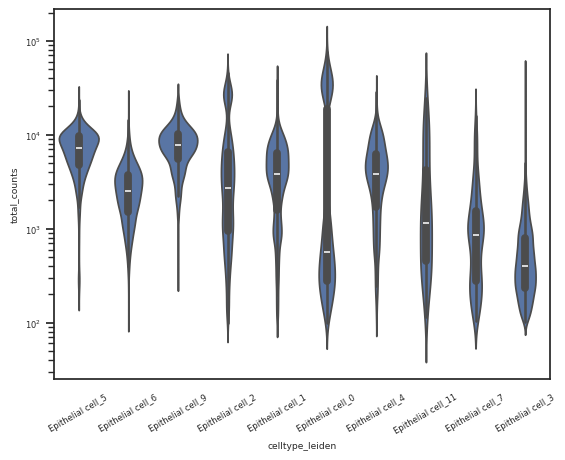

In [65]:
sig = 'HALLMARK_ANDROGEN'
sns.violinplot(obs_data,
    x = 'celltype_leiden',
    y = sig,
    order = celltype_order,
    log_scale=True
)

plt.xticks(rotation=30)


In [56]:
# Compute top genes per decile
sc.tl.rank_genes_groups(
    adata,
    groupby='celltype_leiden',
    method='t-test',   # can also use 'wilcoxon' or 'logreg'
    use_raw=False,
    layer='log1p'
)


deg_df = sc.get.rank_genes_groups_df(adata,log2fc_min=0.5, pval_cutoff=0.05,group=None)


In [57]:
deg_df[deg_df['names'].isin(['AMACR','TACSTD2','KRT5','KRT15','TP63'])]
#deg_df[deg_df['names'].isin(prostate_lineage_signatures_dict['HALLMARK_INTERFERON_ALPHA_RESPONSE'])]['group'].value_counts()
#deg_df[deg_df['group'].isin(['3.0'])][:50]

,group,names,scores,logfoldchanges,pvals,pvals_adj
25,Epithelial cell_0,AMACR,16.771326,1.082952,1.473360e-62,6.351264e-62
203,Epithelial cell_1,TACSTD2,87.868286,2.231200,0.000000e+00,0.000000e+00
16322,Epithelial cell_3,KRT15,22.290831,1.306251,9.010123e-107,1.668652e-105
16337,Epithelial cell_3,KRT5,11.018029,0.906572,5.103512e-28,2.391139e-27
16361,Epithelial cell_4,KRT15,103.848434,4.698161,0.000000e+00,0.000000e+00
16366,Epithelial cell_4,KRT5,72.222450,4.666256,0.000000e+00,0.000000e+00
16416,Epithelial cell_4,TACSTD2,51.126953,1.843675,0.000000e+00,0.000000e+00
16585,Epithelial cell_4,TP63,35.355598,4.681593,2.086412e-230,2.044451e-228
26550,Epithelial cell_5,TACSTD2,32.987167,1.091965,7.323394e-181,3.137352e-179
39617,Epithelial cell_6,AMACR,3.620981,0.690259,3.073489e-04,8.044742e-04


In [26]:
obs_data = adata.obs.copy()
sig = 'CRPC-SCL'#'HALLMARK_INTERFERON_ALPHA_RESPONSE'
obs_data[['decile_cat',sig]].groupby('decile_cat').median().sort_values(sig,ascending=False)

/tmp/ipykernel_756615/3571368614.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_data[['decile_cat',sig]].groupby('decile_cat').median().sort_values(sig,ascending=False)


,CRPC-SCL
decile_cat,
3.0,0.238997
2.0,0.218687
4.0,0.197229
7.0,0.108540
1.0,0.094888
5.0,0.089769
8.0,0.077674
6.0,0.063394
9.0,0.046035


### Save the single cell annotation with AR_HM quantile annotation

In [13]:
decile_cat = 'Epithelial cell_' + adata.obs['decile_cat'].astype(str)

scs_adata.obs['celltype_leiden'] = (
    scs_adata.obs['celltype_leiden']
    .cat.add_categories(decile_cat.unique())
)

scs_adata.obs.loc[decile_cat.index, 'celltype_leiden'] = decile_cat
scs_adata.obs['celltype_leiden'] = scs_adata.obs['celltype_leiden'].cat.remove_unused_categories()
scs_adata.obs

,doublet,doublet_score,sample,type,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden,cell_type,celltype_leiden
HSPC_S07_AGCGGTCAGACTAGAT-1,0.0,10.678799,HSPC_S07,HSPC,4277,11896,1044,8.776059,4,Endothelial cell,Endothelial cell_0
HSPC_S07_CTACACCTCACCATAG-1,0.0,10.678799,HSPC_S07,HSPC,3434,7854,748,9.523810,4,Endothelial cell,Endothelial cell_0
HSPC_S07_ACCAGTAGTCGCGAAA-1,0.0,10.678799,HSPC_S07,HSPC,3782,7683,722,9.397371,4,Endothelial cell,Endothelial cell_2
HSPC_S07_CATCAGAAGGCACATG-1,0.0,2.938393,HSPC_S07,HSPC,1420,4490,447,9.955457,12,Epithelial cell,Epithelial cell_8.0
HSPC_S07_CATTATCTCGCAAACT-1,0.0,2.938393,HSPC_S07,HSPC,407,991,94,9.485368,12,Epithelial cell,Epithelial cell_10.0
...,...,...,...,...,...,...,...,...,...,...,...
PC_S44_GGGAGATGTAGAAAGG-1-1,0.0,26.731888,PC_S44,PC,423,1042,64,6.142035,1,Epithelial cell,Epithelial cell_1.0
PC_S44_GAGTCCGGTCCGAAGA-1-1,0.0,0.554882,PC_S44,PC,382,715,65,9.090909,21,Myeloid cell,Myeloid cell_3
PC_S44_GTACTTTGTTCCCTTG-1-3,0.0,26.731888,PC_S44,PC,465,665,65,9.774436,1,Epithelial cell,Epithelial cell_1.0
PC_S44_ACGCCAGGTAAGGGAA-1,0.0,26.731888,PC_S44,PC,314,893,52,5.823068,1,Epithelial cell,Epithelial cell_1.0


In [14]:
scs_adata.obs['celltype_leiden'].value_counts()

celltype_leiden
T cell_0                20237
T cell_1                15650
T cell_2                 5888
Myeloid cell_0           4287
Myeloid cell_1           4060
Epithelial cell_8.0      3860
Epithelial cell_3.0      3860
Epithelial cell_10.0     3860
Epithelial cell_9.0      3860
Epithelial cell_1.0      3860
Epithelial cell_6.0      3860
Epithelial cell_5.0      3860
Epithelial cell_2.0      3860
Epithelial cell_4.0      3859
Epithelial cell_7.0      3859
Endothelial cell_0       3074
Fibroblast_0             2818
Fibroblast_1             2349
Endothelial cell_1       2278
T cell_3                 1850
Endothelial cell_2       1777
Myeloid cell_2           1766
Endothelial cell_3       1404
T cell_5                 1232
Fibroblast_2             1193
Myeloid cell_3           1080
B cell_0                  952
Mast cell_0               788
B cell_1                  615
Mast cell_1               603
T cell_7                  516
B cell_3                  486
B cell_4                

In [48]:
scs_adata.write(f'/scratch/svc_td_compbio/users/kiviaho/preprocessed_h5ad/lyu_2024_cell_subtypes_with_AR_HM_deciles_for_cell2location_mapping_{formatted_date}.h5ad')